# Compute Bertscore

In [1]:
from evaluate import load
import json

result_path = "bert_score_results.json"

c:\Users\danie\Desktop\Studium\Master's thesis\MA_Code\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
core_claim_json_path = "core_claims_eval.json"

with open(core_claim_json_path, 'r', encoding="utf-8") as j:
    core_claims_eval = json.loads(j.read())

In [3]:
#helper functions for reformating and extracting the dict
def extract_core_claim_dict(article, reformat=True):
    core_claims = {}
    for key, value in article.items():
        if "core_claims" in key:
            core_claims[key] = value
    if (reformat):
        return reformat_core_claim_dict(core_claim_dict=core_claims)
    return core_claims


def reformat_core_claim_dict(core_claim_dict):
    core_claim_comparison = {}
    core_claim_comparison["core_claim_pairs"] = []
    for key_p, value_p in core_claim_dict.items():
        for key_r, value_r in core_claim_dict.items():
            if key_p == key_r:
                continue
            p_r_dict = {}
            p_r_dict['p'] = key_p
            p_r_dict['r'] = key_r
            p_r_dict['claim_pairs'] = []
            for claim_p in value_p:
                claim_pair = {
                    "claims_prediction" : [claim_p] * len(value_r),
                    "claims_reference" : value_r
                }
                p_r_dict['claim_pairs'].append(claim_pair)
            core_claim_comparison['core_claim_pairs'].append(p_r_dict)
    return core_claim_comparison

from evaluate import load
bertscore = load("bertscore")

def get_result_dict(article):
    results_core_claim_comparison = extract_core_claim_dict(article)
    for pair in results_core_claim_comparison['core_claim_pairs']:
        
        pair['scores'] = {}
        
        for i, claim_pair in enumerate(pair['claim_pairs']):
            results = bertscore.compute(predictions=claim_pair['claims_prediction'], references=claim_pair['claims_reference'], model_type="distilbert-base-uncased")
            del results['hashcode']
            pair['scores'][f'claim_{i+1}'] = results
        del pair['claim_pairs']
    return results_core_claim_comparison

In [4]:
results = {}
results['articles'] = []
for article in core_claims_eval['articles']:
    article_dict = {}
    article_dict['article_title']= article['article_title']
    article_dict['results'] = get_result_dict(article)
    results['articles'].append(article_dict)

c:\Users\danie\Desktop\Studium\Master's thesis\MA_Code\venv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\danie\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [10]:
#run only if changes are made to the code above
with open (result_path, "w") as f:
    json.dump(results, f)

# Process and display Results

In [5]:
import json
with open(result_path, 'r', encoding="utf-8") as j:
    results = json.loads(j.read())

In [68]:
# import numpy as np
# for claim, scores in test_example_claims.items():
#     for metric, values in scores.items():
#         scores[f"{metric}"] = np.average(values)

# print (test_example_claims)

{'claim_1': {'precision': np.float64(0.7316822528839111), 'recall': np.float64(0.7246290564537048), 'f1': np.float64(0.7280950546264648), 'precision_avg': np.float64(0.7316822528839111)}, 'claim_2': {'precision': np.float64(0.7658299207687378), 'recall': np.float64(0.7471313357353211), 'f1': np.float64(0.7562829732894898)}, 'claim_3': {'precision': np.float64(0.723418402671814), 'recall': np.float64(0.738398814201355), 'f1': np.float64(0.7306166291236877)}, 'claim_4': {'precision': np.float64(0.7408034801483154), 'recall': np.float64(0.7089059948921204), 'f1': np.float64(0.7243470788002014)}, 'claim_5': {'precision': np.float64(0.7382403254508972), 'recall': np.float64(0.7334891796112061), 'f1': np.float64(0.7357544660568237)}}


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = results

#transform the data into a new dict containing averages and excluding duplicate p-r pairs
pr_pairs = {}
for article in data['articles']:
    for claim_pair in article['results']['core_claim_pairs']:
        pr_pair = frozenset({claim_pair['p'], claim_pair['r']})
        if pr_pair not in pr_pairs:
            pr_pairs[pr_pair] = {'claims': []}
        for claim, metrics in claim_pair['scores'].items():
            avg_precision = sum(metrics['precision']) / len(metrics['precision'])
            avg_recall = sum(metrics['recall']) / len(metrics['recall'])
            avg_f1 = sum(metrics['f1']) / len(metrics['f1'])
            pr_pairs[pr_pair]['claims'].append({
                'Claim': claim,
                'Precision': avg_precision,
                'Recall': avg_recall,
                'F1': avg_f1
            })

rows = []
for pr_pair, details in pr_pairs.items():
    for claim_details in details['claims']:
        pr_str = ', '.join(pr_pair)
        rows.append({
            'Claim': claim_details['Claim'],
            'Metric': 'Precision',
            'Value': claim_details['Precision'], #add each metric into their own row
            'P-R Pair': pr_str,
            'Highlight': '_llama' in pr_str or '_gemini' in pr_str #add a boolean distinction between pairs containing a LLM and ones that don't
        })
        rows.append({
            'Claim': claim_details['Claim'],
            'Metric': 'Recall',
            'Value': claim_details['Recall'],
            'P-R Pair': pr_str,
            'Highlight': '_llama' in pr_str or '_gemini' in pr_str
        })
        rows.append({
            'Claim': claim_details['Claim'],
            'Metric': 'F1',
            'Value': claim_details['F1'],
            'P-R Pair': pr_str,
            'Highlight': '_llama' in pr_str or '_gemini' in pr_str
        })

df = pd.DataFrame(rows)
df



,Claim,Metric,Value,P-R Pair,Highlight
0,claim_1,Precision,0.791067,"core_claims_llama, core_claims_gemini_naive",True
1,claim_1,Recall,0.787880,"core_claims_llama, core_claims_gemini_naive",True
2,claim_1,F1,0.789348,"core_claims_llama, core_claims_gemini_naive",True
3,claim_2,Precision,0.780099,"core_claims_llama, core_claims_gemini_naive",True
4,claim_2,Recall,0.802476,"core_claims_llama, core_claims_gemini_naive",True
...,...,...,...,...,...
1420,claim_4,Recall,0.695392,"core_claims_reader_3, core_claims_reader_4",False
1421,claim_4,F1,0.698061,"core_claims_reader_3, core_claims_reader_4",False
1422,claim_5,Precision,0.670614,"core_claims_reader_3, core_claims_reader_4",False
1423,claim_5,Recall,0.736838,"core_claims_reader_3, core_claims_reader_4",False


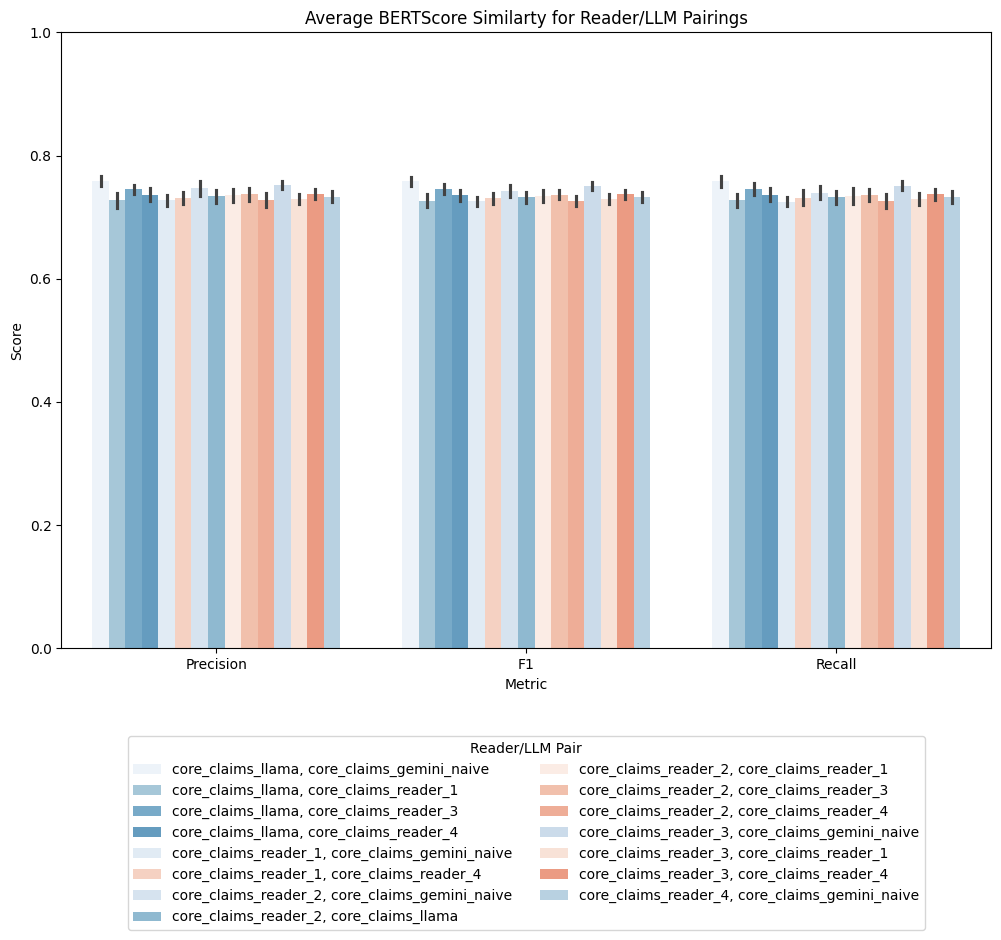

In [19]:
#assigning two custom palette to highlight specific pairs
palette = {}
base_palette = sns.color_palette("Reds", df['P-R Pair'].nunique())
highlight_palette = sns.color_palette("Blues", df['P-R Pair'].nunique())

for pr in df['P-R Pair'].unique():
    if any(x in pr for x in ['_llama', '_gemini']):
        palette[pr] = highlight_palette.pop(0)
    else:
        palette[pr] = base_palette.pop(0)

#plot with distinct colors for highlighted pairs
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Metric', y='Value', hue='P-R Pair', data=df.sort_values(by=['P-R Pair']), palette=palette)
plt.title('Average BERTScore Similarty for Reader/LLM Pairings')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Reader/LLM Pair')
sns.move_legend(ax, "center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.show()


In [8]:
metric_averages = df.groupby(['P-R Pair', 'Metric'])['Value'].mean().sort_index()
metric_averages.sort_index(axis='index', ascending=False)

P-R Pair                                        Metric   
core_claims_reader_3, core_claims_reader_4      Recall       0.737370
                                                Precision    0.737370
                                                F1           0.737029
core_claims_reader_3, core_claims_reader_2      Recall       0.735990
                                                Precision    0.737195
                                                F1           0.735992
core_claims_reader_3, core_claims_llama         Recall       0.745369
                                                Precision    0.745369
                                                F1           0.745133
core_claims_reader_2, core_claims_reader_4      Recall       0.726890
                                                Precision    0.727982
                                                F1           0.726496
core_claims_reader_1, core_claims_reader_4      Recall       0.731155
                                

In [60]:
from scipy import stats
import numpy as np

# Calculate metric averages
metric_averages = df.groupby(['Metric', 'P-R Pair'])['Value'].mean().reset_index()

# Apply z-score transformation
metric_averages['Z-Score'] = metric_averages.groupby(['Metric'])['Value'].transform(lambda x: stats.zscore(x))

# Identify outliers
outliers = metric_averages[np.abs(metric_averages['Z-Score']) > 2]

print("Outliers based on Z-Score:")
print(outliers)


Outliers based on Z-Score:
       Metric                                     P-R Pair     Value   Z-Score
0          F1  core_claims_gemini_naive, core_claims_llama  0.758054  2.412668
15  Precision  core_claims_gemini_naive, core_claims_llama  0.758686  2.363419
30     Recall  core_claims_gemini_naive, core_claims_llama  0.757961  2.456184


Further Descriptive Statistics

In [15]:
total_averages = df.groupby('Metric')['Value'].mean()
print(total_averages)

Metric
F1           0.736555
Precision    0.737669
Recall       0.736522
Name: Value, dtype: float64


In [148]:
minimum_values = df.groupby(['P-R Pair', 'Metric'])['Value'].min()
minimum_values

P-R Pair                                        Metric   
core_claims_gemini_naive, core_claims_reader_1  F1           0.681997
                                                Precision    0.645224
                                                Recall       0.668887
core_claims_gemini_naive, core_claims_reader_3  F1           0.711808
                                                Precision    0.701665
                                                Recall       0.711512
core_claims_llama, core_claims_gemini_naive     F1           0.708579
                                                Precision    0.697367
                                                Recall       0.695309
core_claims_llama, core_claims_reader_1         F1           0.666878
                                                Precision    0.635502
                                                Recall       0.675033
core_claims_llama, core_claims_reader_2         F1           0.676012
                                

In [149]:
maximum_values = df.groupby(['P-R Pair', 'Metric'])['Value'].max()
maximum_values

P-R Pair                                        Metric   
core_claims_gemini_naive, core_claims_reader_1  F1           0.766719
                                                Precision    0.781620
                                                Recall       0.781428
core_claims_gemini_naive, core_claims_reader_3  F1           0.791694
                                                Precision    0.795607
                                                Recall       0.810998
core_claims_llama, core_claims_gemini_naive     F1           0.791072
                                                Precision    0.793625
                                                Recall       0.804437
core_claims_llama, core_claims_reader_1         F1           0.771700
                                                Precision    0.790004
                                                Recall       0.781068
core_claims_llama, core_claims_reader_2         F1           0.791804
                                

In [18]:
std = df.groupby(['P-R Pair', 'Metric'])['Value'].std()
std

P-R Pair                                        Metric   
core_claims_gemini_naive, core_claims_llama     F1           0.023286
                                                Precision    0.022568
                                                Recall       0.027668
core_claims_gemini_naive, core_claims_reader_4  F1           0.025139
                                                Precision    0.025356
                                                Recall       0.029591
core_claims_llama, core_claims_reader_4         F1           0.026332
                                                Precision    0.029089
                                                Recall       0.031158
core_claims_reader_1, core_claims_gemini_naive  F1           0.021408
                                                Precision    0.026566
                                                Recall       0.024940
core_claims_reader_1, core_claims_llama         F1           0.028661
                                